# Estimate Noisy Envelope
---
This notebook estimates Noisy [1,2] envelopes from generated movies. 

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import xarray as xr
import scipy as sci
from matplotlib import animation
from  scipy.spatial import distance
import skimage.transform
from pynoisy import eht_functions as ehtf
import ehtim as eh

Welcome to eht-imaging! v  1.1.1


In [20]:
"""
Function definitions
"""
def load_fits(path):
    image = eh.image.load_fits(path)
    image = image.regrid_image(image.fovx(), pynoisy.core.get_image_size()[0])
    return pynoisy.envelope.grid(data=image.imarr())

def rbf_kernel_covariance(x, y, sigma=1):
    """Exponentiated quadratic distance"""
    xa = np.stack((x.ravel(), y.ravel()), axis=1)
    norm = -0.5 * distance.cdist(xa, xa, 'sqeuclidean') / sigma**2
    return np.exp(norm)

def generate_correlated_noise(sigma=0.05):
    grid = pynoisy.utils.get_grid()
    num_frames = pynoisy.core.get_num_frames()
    x, y = np.meshgrid(grid.x, grid.y)
    cov = rbf_kernel_covariance(x, y, sigma)
    correlated_noise = np.random.multivariate_normal(
        mean=np.zeros((grid.dims['x'], grid.dims['y'])).ravel(), 
        cov=cov, size=num_frames).reshape(num_frames, grid.dims['x'], grid.dims['y'])
    return correlated_noise

def generate_rotating_envelope(path):
    envelope = load_fits(path)
    
    # Mask enevlope before rotation
    mask = np.ones(envelope.shape)
    mask[envelope.r > 0.5] = 0
    envelope *= mask
    
    angles = np.linspace(0, 360, pynoisy.core.get_num_frames())
    rotating_envelope = []
    for angle in angles:
        rotating_envelope.append(skimage.transform.rotate(envelope.data, angle))
    return np.array(rotating_envelope)

def plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime=300, logplot=False):
    fig, ax = plt.subplots(1,2, figsize=(10,6))
    obs_sgra.plotall('uvdist','amp', axis=ax[0], label='SgrA', legend=True, ebar=False, logplot=logplot);
    obs_noisy.plotall('uvdist','amp', axis=ax[0], label='Noisy', legend=True, marker='^', color='r', ebar=False, logplot=logplot);
    ax[0].set_title('No average', fontsize=12);
    ax[0].legend()
    obs_sgr_avg.plotall('uvdist','amp', axis=ax[1], label='SgrA', legend=True, ebar=False, logplot=logplot);
    obs_noisy_avg.plotall('uvdist','amp', axis=ax[1], label='Noisy', legend=True, marker='^', color='r', ebar=False, logplot=logplot);
    ax[1].set_title('{}s Average'.format(inttime), fontsize=12);
    ax[1].legend()
    
def plot_closure_phases(obs_sgra, obs_noisy, triangles=[['AZ', 'SM', 'SP'],['AA', 'SM', 'LM']]):
    fig, axes = plt.subplots(2, len(triangles), figsize=(8,8))
    all_sites = ['AA','AP','AZ','LM','PV','SM','JC','SP','SR']
    for i, triangle in enumerate(triangles):
        eh.plot_cphase_obs_compare([obs_sgra, obs_noisy], *triangle, axis=axes[0,i], 
                                   ebar=False, legendlabels=['SgrA', 'Noisy'])
        axes[0,i].legend()
        
        triangle_obs = all_sites.copy()
        for site in triangle:
            triangle_obs.remove(site)
        obs = obs_sgra.flag_sites(triangle_obs)
        obs.plotall('u','v', axis=axes[1,i], conj=True, rangey=[-1e10, 1e10], rangex=[-1e10, 1e10])
    fig.tight_layout()

## Correlated GRF

In [10]:
advection = pynoisy.advection.disk()
diffusion = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection, diffusion)

source = generate_correlated_noise()

correlated_field = solver.run_symmetric(source=source, verbose=True)

100%|██████████| 1/1 [00:17<00:00, 17.70s/it]


<IPython.core.display.Javascript object>


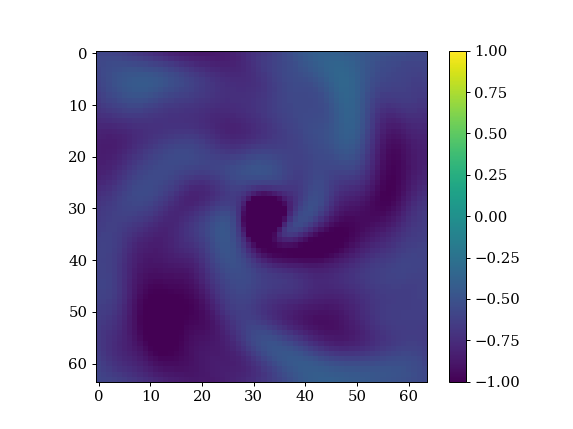

In [12]:
%matplotlib notebook
correlated_field.noisy_methods.get_animation(vmin=-1, vmax=1)

## Dynamic Envelope

In [22]:
path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/dbsrc_fiducial/dbsrc_fiducial.fits'
rotating_envelope = generate_rotating_envelope(path)
rotating_envelope = xr.DataArray(
    data=rotating_envelope,
    coords=correlated_field.coords
)

Loading fits image:  /home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/dbsrc_fiducial/dbsrc_fiducial.fits
reading stokes images from top HDU -- assuming IQUV


<IPython.core.display.Javascript object>


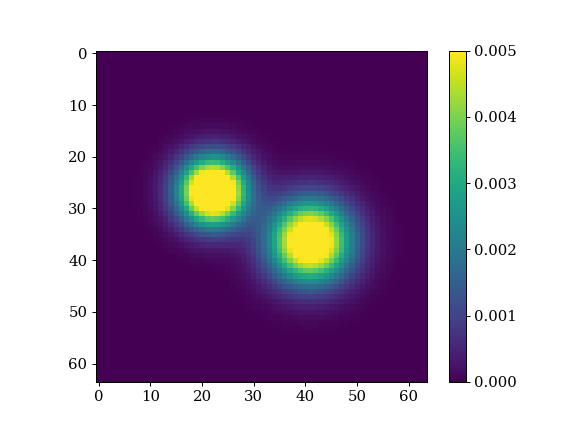

In [25]:
%matplotlib notebook

rotating_envelope.noisy_methods.get_animation(vmin=0, vmax=0.005)

<IPython.core.display.Javascript object>


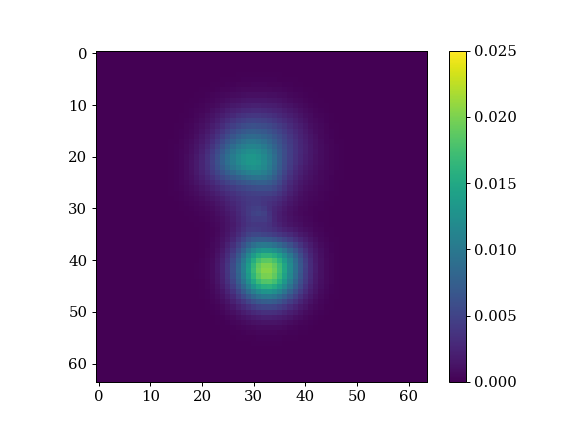

In [39]:
alpha = 0.7
dynamic_correlated_field = rotating_envelope * np.exp(-alpha * correlated_field)
dynamic_correlated_field.noisy_methods.get_animation(vmin=0, vmax=0.025)

## EHT imaging

In [42]:
ehtim_home = '/home/aviad/Code/eht-imaging/'
uvfits_path = 'SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_10s.uvfits'
obs_sgra = ehtf.load_sgra_obs(ehtim_home, uvfits_path)
movie = ehtf.ehtim_movie(np.array(dynamic_correlated_field), obs_sgra, normalize_flux=False, 
                         fov=7.7570188977504e-10, fov_units='rad')
obs_noisy = ehtf.generate_observations(movie, obs_sgra)

#ehtf.export_movie(movie.im_list(), './dbsrc_rotating_correlated.mp4')

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!

Merging 50 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 


Warning!: in add_jones_and_noise, some SEFDs are <= 0!
Resorting to data point sigmas, which may add too much systematic noise!
   Applying gain corruption: ampcal-->False
   Applying atmospheric phase corruption: phasecal-->False
   Applying D Term mixing: dcal-->False
   Applying Field Rotation: frcal-->False
Adding thermal noise to data . . . 


<IPython.core.display.Javascript object>


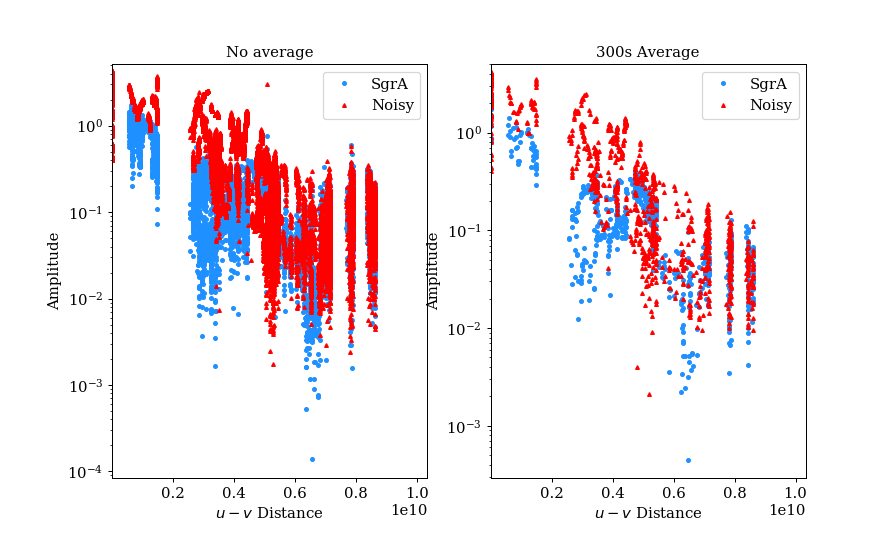

/home/aviad/Code/eht-imaging/ehtim/obsdata.py:3854: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  x.set_ylim(rangey)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


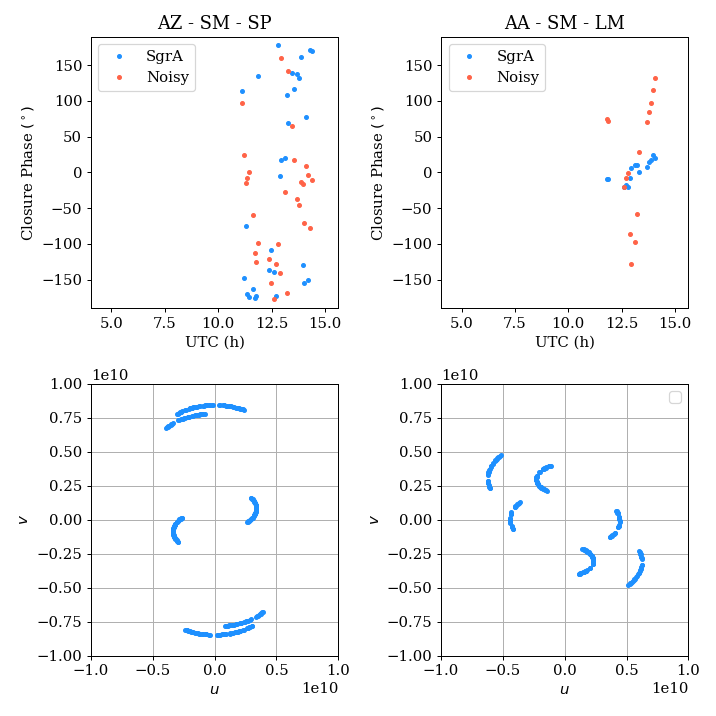

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [43]:
inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)

plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime, logplot=True)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)